Dataset




In [55]:
!wget http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat
!wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
from scipy.io import loadmat
dataset=loadmat('Indian_pines.mat')
groundtruth=loadmat('Indian_pines_gt.mat')


--2020-07-02 08:50:57--  http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6296374 (6.0M) [text/plain]
Saving to: ‘Indian_pines.mat.1’

Indian_pines.mat.1  100%[===================>]   6.00M   577KB/s    in 13s     

2020-07-02 08:51:10 (483 KB/s) - ‘Indian_pines.mat.1’ saved [6296374/6296374]

--2020-07-02 08:51:12--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat.1’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-07-02 08:51:12 (149 MB/s) - ‘Indian_pines_gt.mat.1’ saved [1125/1125]

Mount G-Drive 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'HybridSN1'
path = F"/content/gdrive/My Drive/{model_save_name}"
path1=F"/content/gdrive/My Drive/Validation1"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import numpy as np

dataset.keys()
data=dataset['indian_pines']
ground=groundtruth['indian_pines_gt']
print(np.shape(ground))
data=np.array(data)
ground=np.array(ground)
#ground=ground.astype('int64')

(145, 145)


PCA

In [6]:
#PCA
from sklearn.decomposition import PCA
def pcak(k,data):
 pca=PCA(n_components=k,whiten=True)
 data1=np.reshape(data,(-1,data.shape[2]))
 data1=pca.fit_transform(data1)
 data1=np.reshape(data1,(data.shape[0],data.shape[1],k))
 data=data1
 #data=data.astype('float32')
 return data
data=pcak(30,data)


PAD WITH ZEROS

In [7]:

def padwithzeros(data,margin):
  x_new=np.zeros((data.shape[0]+2*margin,data.shape[1]+2*margin,data.shape[2]))
  x_new[margin:data.shape[0]+margin,margin:data.shape[1]+margin,:]=data
  return x_new
data1=padwithzeros(data,margin=12)
#ground=padwithzeros(ground#,margin=2)
print(data.shape[0])

145


NEIGHBOURING PATCHES

In [8]:
def createImageCubes(X, y, windowSize=25, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padwithzeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels



data,ground=createImageCubes(data, ground, windowSize=25)
data=data.astype('float32')
ground=ground.astype('int64')
#print(np.shape(data),np.shape(ground),data.dtype,ground.dtype)

TRAINING AND VALIDATION DATASET

In [9]:
from sklearn.model_selection import train_test_split  
testRatio=0.7
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test
train,val,ground_train,ground_val=splitTrainTestSet(data, ground, testRatio, randomState=345)
print(np.shape(train),np.shape(val),np.shape(ground_train),np.shape(ground_val))


(3074, 25, 25, 30) (7175, 25, 25, 30) (3074,) (7175,)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


CUSTOM DATASET & DATALOADER

In [11]:

from torch.utils.data import DataLoader, Dataset

class indianpines(Dataset):
  def __init__(self,data,ground):
    self.data=torch.reshape(torch.from_numpy(data),(np.shape(data)[0],1,np.shape(data)[3],np.shape(data)[1],np.shape(data)[2]))
    self.ground=(torch.from_numpy(ground))
  def __len__(self):
    return(self.data.size(0))
  def __getitem__(self,index):
    data_model=self.data[index]
    ground_model=self.ground[index]

    return data_model,ground_model
train_dataset=indianpines(train,ground_train)
#rint(train_dataset[5])
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
val_dataset=indianpines(val,ground_val)
#print(val_dataset[1])
val_loader=DataLoader(val_dataset,batch_size=256)


HYBRIDSN

In [12]:
class HybridSN(nn.Module):

  def __init__(self):
    super(HybridSN,self).__init__()
    self.layer1=nn.Sequential(nn.Conv3d(1,8,(7,3,3)),nn.ReLU())
    self.layer2=nn.Sequential(nn.Conv3d(8,16,(5,3,3)),nn.ReLU())
    self.layer3=nn.Sequential(nn.Conv3d(16,32,(3,3,3)),nn.ReLU())
    self.layer4=nn.Sequential(nn.Conv2d(576,64,(3,3)),nn.ReLU())
    self.layer5=nn.Sequential(nn.Linear(18496,256),nn.ReLU())
    self.layer6=nn.Sequential(nn.Dropout(p=0.4),nn.ReLU())
    self.layer7=nn.Sequential(nn.Linear(256,128),nn.ReLU())
    self.layer8=nn.Sequential(nn.Dropout(p=0.4),nn.ReLU())
    self.layer9=nn.Sequential(nn.Linear(128,16))
  def forward(self,x):
    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=x.reshape(x.size(0),-1,x.size(3),x.size(4))
    #print(x.size())
    x=self.layer4(x)
    x=x.reshape(x.size(0),-1)
    x=self.layer5(x)
    x=self.layer6(x)
    x=self.layer7(x)
    x=self.layer8(x)
    out=self.layer9(x)
    return out


PARAMETERS

In [13]:
###Parameters###
lr=0.001
epochs=150


MODEL & OPTIMIZER INITIALIZATION

In [14]:
model=HybridSN()
model.cuda()
import torch.optim as optim
opt=optim.Adam(model.parameters(),lr=lr,weight_decay=1e-06)

# checkpoint=torch.load(path)
# model.load_state_dict(checkpoint['model_state_dict'])
# opt.load_state_dict(checkpoint['optimizer_state_dict'])

LOSS FUNCTION

In [15]:
loss_function=F.cross_entropy
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    #print(loss)
    if opt is not None:
        #print(1)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
       
    return loss.item(), len(xb)


In [16]:
def accuracy(out,y):
 
  preds=torch.argmax(out,dim=1)
  #print(preds)
  return torch.sum(preds==y).item()

TRAINING DATA

In [19]:
 history=[]
 history=list(history)
 for epoch in range(epochs):
    model.train()
    t_loss=0
    t_num=0
    correct=0
    
    for x,y in train_loader:
      x=x.to('cuda')
      y=y.to('cuda')
      accuracy(model(x),y)
      a,b=loss_batch(model,loss_function,x,y,opt)
      correct_class=accuracy(model(x),y)
      correct += correct_class
      t_loss += a*b
      t_num += b
    train_loss=t_loss/t_num
   
    acc=correct/t_num
    print(train_loss,epoch,acc)
    x=[train_loss,acc,epoch]
    history.append(x)
    # torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': opt.state_dict(),'checkpoint':history},path)

2.599456390313848 0 0.14378659726740403
2.4339407829006694 1 0.2338972023422251
2.3889414127104143 2 0.2117761873780091
2.37029965876292 3 0.21470396877033182
2.3676208807573587 4 0.2358490566037736
2.3518183986785433 5 0.2391021470396877
2.4039718057710626 6 0.23519843851659075
2.3484122787269586 7 0.2335718932986337
2.3169595101628895 8 0.2283669486011711
2.3367813046132113 9 0.23552374756018218
2.2678904420924635 10 0.24007807417046195
2.306615954416482 11 0.24007807417046195
2.259273216331944 12 0.24105400130123616
2.1954937731203663 13 0.23975276512687052
2.297541548078062 14 0.23162003903708522
2.187715710334058 15 0.23454782042940794
2.1445425704616032 16 0.2608978529603123
2.180223537329039 17 0.2618737800910865
2.1137230562248552 18 0.29050097592713076
2.049453139770473 19 0.3109954456733897
2.0219786460320517 20 0.3243331164606376
1.9585301781445257 21 0.328562134027326
1.9076392922063268 22 0.33994795055302535
1.888742158067017 23 0.33897202342225113
1.9017021574598671 24 0.

VALIDATION REPORT

In [20]:
y_predicted=[]
model.eval()
for x,y in val_loader:
  x=x.to('cuda')
  c=torch.argmax(model(x),dim=1)
  y_predicted.append(c)
 
for i in range(len(y_predicted)):
  if i==0:
    y1=y_predicted[i]
  else:
    y1=torch.cat((y1,y_predicted[i]),dim=0)


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
y_test=ground_val
y2=y1.cpu()
y2=y2.numpy()

classification=classification_report(y_test,y2)
print(classification)
confusion=confusion_matrix(y_test,y2)
# torch.save({'confusion':confusion,'Validation Report':classification},path1)

              precision    recall  f1-score   support

           0       0.91      0.66      0.76        32
           1       0.95      0.94      0.95      1000
           2       0.95      0.98      0.97       581
           3       0.86      0.89      0.88       166
           4       0.97      0.91      0.94       338
           5       0.98      0.97      0.97       511
           6       0.62      0.75      0.68        20
           7       0.99      0.99      0.99       335
           8       0.76      0.93      0.84        14
           9       0.96      0.95      0.95       680
          10       0.97      0.99      0.98      1719
          11       0.96      0.91      0.93       415
          12       0.95      0.97      0.96       143
          13       0.98      1.00      0.99       886
          14       0.93      0.90      0.92       270
          15       0.81      0.97      0.88        65

    accuracy                           0.96      7175
   macro avg       0.91   

In [21]:
data=dataset['indian_pines']
y=groundtruth['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

data=pcak(30,data)
X=padwithzeros(data,margin=12)
PATCH_SIZE=25

In [22]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

Prediction of Complete Dataset

In [23]:
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            with torch.no_grad():
              X_test_image = image_patch.reshape(1,1,image_patch.shape[2],image_patch.shape[0], image_patch.shape[1]).astype('float32')                                   
              X_test_image=torch.from_numpy(X_test_image)
              X_test_image=X_test_image.cuda()
              prediction = model(X_test_image).cpu()
              predict = prediction.numpy()         
              prediction = np.argmax(predict, axis=1)
              outputs[i][j] = prediction+1

Classification MAP

Text(250, 105, 'Stone-Steel-Towers')

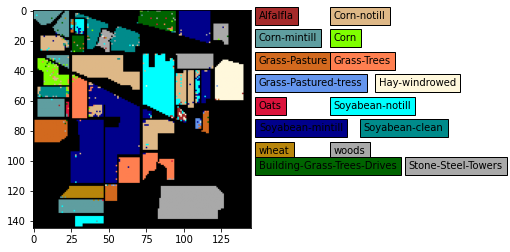

In [25]:
import matplotlib.pyplot as plt 
import matplotlib._color_data as mcd
import matplotlib.colors as ce
x=[name for name in mcd.CSS4_COLORS]
s=np.shape(outputs)
rgb=np.zeros((s[0],s[1],3))
 
for i in range(s[0]):
  for j in range(s[1]):
     k=outputs[i,j]

     if k==0:
       continue
     else:
      rgb[i,j,:]= ce.to_rgb(x[int(k)+10])

plt.imshow(rgb)
plt.text(150,5,'Alfalfla',bbox=dict(facecolor=ce.to_rgb(x[int(1)+10])))
plt.text(200,5,'Corn-notill',bbox=dict(facecolor=ce.to_rgb(x[int(2)+10])))
plt.text(150,20,'Corn-mintill',bbox=dict(facecolor=ce.to_rgb(x[int(3)+10])))
plt.text(200,20,'Corn',bbox=dict(facecolor=ce.to_rgb(x[int(4)+10])))
plt.text(150,35,'Grass-Pasture',bbox=dict(facecolor=ce.to_rgb(x[int(5)+10])))
plt.text(200,35,'Grass-Trees',bbox=dict(facecolor=ce.to_rgb(x[int(6)+10])))
plt.text(150,50,'Grass-Pastured-tress',bbox=dict(facecolor=ce.to_rgb(x[int(7)+10])))
plt.text(230,50,'Hay-windrowed',bbox=dict(facecolor=ce.to_rgb(x[int(8)+10])))
plt.text(150,65,'Oats',bbox=dict(facecolor=ce.to_rgb(x[int(9)+10])))
plt.text(200,65,'Soyabean-notill',bbox=dict(facecolor=ce.to_rgb(x[int(10)+10])))
plt.text(150,80,'Soyabean-mintill',bbox=dict(facecolor=ce.to_rgb(x[int(11)+10])))
plt.text(220,80,'Soyabean-clean',bbox=dict(facecolor=ce.to_rgb(x[int(12)+10])))
plt.text(150,95,'wheat',bbox=dict(facecolor=ce.to_rgb(x[int(13)+10])))
plt.text(200,95,'woods',bbox=dict(facecolor=ce.to_rgb(x[int(14)+10])))
plt.text(150,105,'Building-Grass-Trees-Drives',bbox=dict(facecolor=ce.to_rgb(x[int(15)+10])))
plt.text(250,105,'Stone-Steel-Towers',bbox=dict(facecolor=ce.to_rgb(x[int(16)+10])) ) 


GroundTruth



Text(250, 105, 'Stone-Steel-Towers')

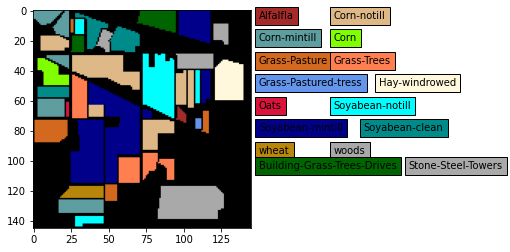

In [26]:
import matplotlib.pyplot as plt 
import matplotlib._color_data as mcd
import matplotlib.colors as ce
x=[name for name in mcd.CSS4_COLORS]
s=np.shape(y)
rgb=np.zeros((s[0],s[1],3))
 
for i in range(s[0]):
  for j in range(s[1]):
     k=y[i,j]

     if k==0:
       continue
     else:
      rgb[i,j,:]= ce.to_rgb(x[int(k)+10])

plt.imshow(rgb)
plt.text(150,5,'Alfalfla',bbox=dict(facecolor=ce.to_rgb(x[int(1)+10])))
plt.text(200,5,'Corn-notill',bbox=dict(facecolor=ce.to_rgb(x[int(2)+10])))
plt.text(150,20,'Corn-mintill',bbox=dict(facecolor=ce.to_rgb(x[int(3)+10])))
plt.text(200,20,'Corn',bbox=dict(facecolor=ce.to_rgb(x[int(4)+10])))
plt.text(150,35,'Grass-Pasture',bbox=dict(facecolor=ce.to_rgb(x[int(5)+10])))
plt.text(200,35,'Grass-Trees',bbox=dict(facecolor=ce.to_rgb(x[int(6)+10])))
plt.text(150,50,'Grass-Pastured-tress',bbox=dict(facecolor=ce.to_rgb(x[int(7)+10])))
plt.text(230,50,'Hay-windrowed',bbox=dict(facecolor=ce.to_rgb(x[int(8)+10])))
plt.text(150,65,'Oats',bbox=dict(facecolor=ce.to_rgb(x[int(9)+10])))
plt.text(200,65,'Soyabean-notill',bbox=dict(facecolor=ce.to_rgb(x[int(10)+10])))
plt.text(150,80,'Soyabean-mintill',bbox=dict(facecolor=ce.to_rgb(x[int(11)+10])))
plt.text(220,80,'Soyabean-clean',bbox=dict(facecolor=ce.to_rgb(x[int(12)+10])))
plt.text(150,95,'wheat',bbox=dict(facecolor=ce.to_rgb(x[int(13)+10])))
plt.text(200,95,'woods',bbox=dict(facecolor=ce.to_rgb(x[int(14)+10])))
plt.text(150,105,'Building-Grass-Trees-Drives',bbox=dict(facecolor=ce.to_rgb(x[int(15)+10])))
plt.text(250,105,'Stone-Steel-Towers',bbox=dict(facecolor=ce.to_rgb(x[int(16)+10])) ) 


Training Loss Plot

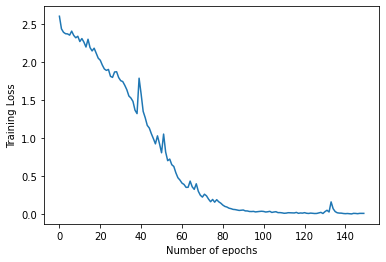

In [42]:
x=torch.load(path)
history=x['checkpoint']

train_loss=np.array(history)[:,0]
epochs=np.array(history)[:,2]
accuracy=np.array(history)[:,1]
import matplotlib.pyplot as plt

plt.ylabel('Training Loss')
plt.xlabel('Number of epochs')
plt.plot(epochs,train_loss)


Accuracy

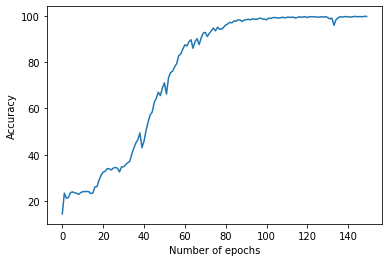

In [41]:
x=torch.load(path)
history=x['checkpoint']

epochs=np.array(history)[:,2]
accuracy=np.array(history)[:,1]
import matplotlib.pyplot as plt

plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.plot(epochs,accuracy*100)

Validation Results

In [36]:
x=torch.load(path1)
history=x['Validation Report']
print(history)

              precision    recall  f1-score   support

           0       0.91      0.66      0.76        32
           1       0.95      0.94      0.95      1000
           2       0.95      0.98      0.97       581
           3       0.86      0.89      0.88       166
           4       0.97      0.91      0.94       338
           5       0.98      0.97      0.97       511
           6       0.62      0.75      0.68        20
           7       0.99      0.99      0.99       335
           8       0.76      0.93      0.84        14
           9       0.96      0.95      0.95       680
          10       0.97      0.99      0.98      1719
          11       0.96      0.91      0.93       415
          12       0.95      0.97      0.96       143
          13       0.98      1.00      0.99       886
          14       0.93      0.90      0.92       270
          15       0.81      0.97      0.88        65

    accuracy                           0.96      7175
   macro avg       0.91   

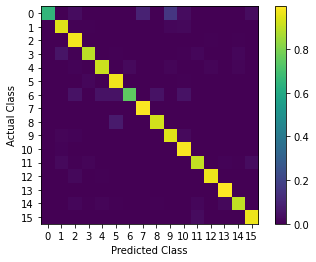

In [54]:
x=torch.load(path1)
history=x['confusion']
from sklearn.preprocessing import normalize
history=normalize(history,norm='l1',axis=1)
plt.xticks(range(16))
plt.yticks(range(16))
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.imshow(history,cmap='viridis')
plt.colorbar()
